In [1]:
import os
from AnnotationCoverageRatio import acr_modules as acr_module
import glob
import numpy as np
import librosa
from pathlib import Path

import soundfile as sf
import pandas as pd
import tqdm

import matplotlib.pyplot as plt
import mir_eval
import mir_eval.util as util
import IPython.display as ipd


Beat_FPS = 100

y_tick_dict ={
    'onbeat':'onbeat', 
    'offbeat':'offbeat', 
    'double':'double', 
    'triple':'triple', 
    'quadruple':'quadruple',  
    'half':'half', 
    'third':'third', 
    'quarter': 'quarter', 
    'any': 'any'} 

c_types=['onbeat', 'offbeat', 'half', 'third',  'quarter',
         'double', 'triple', 'quadruple', 
         'any']
c_ticks = {y_tick_dict[y]:ind for ind, y in enumerate(c_types)}

### Sonification
def add_click(audio, beat_time, sr, click_freq = 1000 ):
    if len(audio.shape)>1 and audio.shape[1]==2:
        audio = audio.sum(axis = 1)/2
        print("audio to mono:", audio.shape)
    click = librosa.clicks(times = beat_time, sr = sr, click_freq = click_freq, length = len(audio))
    audio_withclick = audio + 0.4*click
    return audio_withclick

def getSRCs(selected_track):
    """
    get annpath, wav, activation, estimation of this selected track, and return in a dict

    """
    src_dict = {
        'annpath': os.path.join('./', 'annotations', os.path.basename(selected_track).replace('.wav', '.beats')), 
        'wavpath': os.path.join('./', 'audio', os.path.basename(selected_track)), 
        'actipath': os.path.join('./', 'activations', os.path.basename(selected_track).replace('.wav', '.npy')),
        'estipath': os.path.join('./', 'estimations', os.path.basename(selected_track).replace('.wav', '.beats')),
        }
    
    
    return src_dict

def plotSRCs(src_dict, annshift, figsize = (12, 8), fontsize = 11, start_frame = 0, dur = 1000):
    #%%
    ### get audio
    wavform, rate = sf.read(src_dict['wavpath'])
    if len(wavform.shape)==2:
        wavform = wavform.mean(axis = 1)
    ### get beat ann
    beat_ann = np.loadtxt(src_dict['annpath'])[:, 0]
    ### get beat est
    try:
        beat_est = np.loadtxt(src_dict['estipath'])
    except:
        beat_est = np.loadtxt(src_dict['estipath'].replace('.beats', '.txt'))
    ### get shifted beats
    beat_annshift = beat_ann + annshift*0.001
    ### get activations
    mmacti = np.load(src_dict['actipath'])
    max_acti = mmacti.max(axis = 1)
    
    figheight1 = max_acti.max()+0.1
    fig, axs = plt.subplots(2, 1, figsize = figsize)

    
    ### plot activation with time stamps (beat ann, est, shifted ann)
    axs[0].plot(max_acti, label = 'max-activation', color = 'red', linewidth = 4)
    ### convert x ticks from frames to seconds
    xticks = np.arange(0, int(len(max_acti)), 100)
    axs[0].set_xticks(xticks)
    axs[0].set_xticklabels(xticks/Beat_FPS)
    
    axs[0].set_xlim([start_frame, start_frame + dur])
    axs[0].set_ylim([0, figheight1])
    axs[0].vlines(beat_ann*Beat_FPS, 0, 1, linestyle = 'solid', 
                  label = 'original annotation', color = 'gray', linewidth = 6, alpha = 0.4)
    axs[0].vlines(beat_est*Beat_FPS, 0, 1, linestyle = 'dashed', linewidth = 3, 
                  label = 'sppk estimation', color = 'black')
    annshift_label = str(annshift) + 'ms shifted annotation'
    axs[0].vlines(beat_annshift*Beat_FPS, 0, 1, linestyle = 'solid', linewidth = 6, alpha = 0.4, 
                  label = annshift_label, color = 'orange')
    
    # axs[0].legend(bbox_to_anchor = (1.0, 1.0))
    axs[0].legend(loc='upper center', bbox_to_anchor = (0.5, 1.4), 
                     frameon=False, fontsize = fontsize, ncol=4, 
                     handletextpad=0.3, columnspacing= 0.7)
    # axs[0].set_xlabel('Time (frame, FPS=100)', fontsize = fontsize)
    axs[0].set_xlabel('Time (second)', fontsize = fontsize)
    
    ### plot wavform with time stamps (beat ann, est, shifted ann)
    figheight2 = wavform.max()+0.1
    figlow = wavform.min()-0.1
    axs[1].plot(wavform, label = 'audio-waveform', color = 'blue', linewidth = 4, alpha = 0.7)
    ### convert x ticks from samples to seconds
    xticks = np.arange(0, int(len(wavform)), rate)
    axs[1].set_xticks(xticks)
    axs[1].set_xticklabels(xticks/rate)
    
    axs[1].set_xlim([start_frame/Beat_FPS*rate, start_frame/Beat_FPS*rate + dur/Beat_FPS*rate])
    axs[1].set_ylim([figlow, figheight2])
    axs[1].vlines(beat_ann*rate, figlow, 1, linestyle = 'solid', 
                  label = 'original annotation', color = 'gray', linewidth = 6, alpha = 0.4)
    axs[1].vlines(beat_est*rate, figlow, 1, linestyle = 'dashed', linewidth = 3, 
                  label = 'sppk estimation', color = 'black')
    annshift_label = str(annshift) + 'ms shifted annotation'
    axs[1].vlines(beat_annshift*rate, figlow, 1, linestyle = 'solid', linewidth = 6, alpha = 0.4, 
                  label = annshift_label, color = 'orange')
    
    # axs[0].legend(bbox_to_anchor = (1.0, 1.0))
    axs[1].legend(loc='upper center', bbox_to_anchor = (0.5, 1.4), 
                     frameon=False, fontsize = fontsize, ncol=4, 
                     handletextpad=0.3, columnspacing= 0.7)
    # xlabel = 'Time (sameple, sampling rate:{} Hz)'.format(rate)
    # axs[1].set_xlabel(xlabel, fontsize = fontsize)
    axs[1].set_xlabel('Time (second)', fontsize = fontsize)
    fig.tight_layout()
    return fig

def fullTrackACR(beat_est, beat_ann, tolerance = 0.07, L=2, fontsize = 12, title = None,
                 half_offbeat = True, double= True, half= True, 
                 third_offbeat = True, triple= True, third=True, 
                 quadruple = True,
                 return_dict = False, quarter = True,
                 return_cframe = True, FPS = 100):
    acr_res = acr_module.anyMetLev_eval(beat_est, beat_ann, tolerance = 0.07, L =L,
                      half_offbeat = half_offbeat, 
                      double= double, half = half, 
                      third_offbeat = third_offbeat, 
                      triple = triple, third = third, 
                      quadruple = quadruple,
                      return_dict = return_dict, quarter = quarter,
                      return_cframe = return_cframe, FPS = FPS)
    c_list = []
    for c_type in acr_module.c_types:
        c_list.append(acr_res['correct_frame_results'][c_type][:, np.newaxis])
    c_array = np.array(c_list).squeeze()
    # c_dicts = {est_type: c_array}
    #########################
    # ACR -- Overview Plot
    #########################
    # if est_type in ppts_2overview:
    fig, ax = plt.subplots(1, 1, figsize = (7, 2))
    ax.imshow(c_array, aspect = 'auto', cmap = 'Greens', interpolation='none')
    ax.set_yticks(range(len(c_ticks)) )
    ax.grid(axis='y', linewidth = 1)
    ax.set_yticklabels(c_ticks, fontsize = fontsize)
    ax.tick_params(axis = 'y', rotation = 30)
    ax.get_yaxis().set_label_coords(-0.2,0.5)
    if title:
        ax.set_title(title)
    xticks = np.arange(0, int(len(c_array.T)), 5000)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks/Beat_FPS)
    ax.set_xlabel('Time (seconds)')
    
    return fig

In [2]:
##########################################################################################################
# Sort the csv data, and display the top-5 tracks with largest F1-score improvement after shifting
##########################################################################################################

display_rows = 5
display_keys = ['Dataset', 'F1 improve',  'best_annshifts','F1-ori', 'P-ori', 'R-ori', 'F1-max', 'P-max', 'R-max', 'Model'] # , 'Songpath'
pd.options.display.float_format = "{:,.2f}".format

csv_rpath = './annotation-shift-issues.csv'
all_df = pd.read_csv(csv_rpath)
all_df = all_df.sort_values(by=['F1 improve'], ascending = False)

display_df = all_df.loc[:, display_keys].iloc[:display_rows, :]
display(display_df)

,Dataset,F1 improve,best_annshifts,F1-ori,P-ori,R-ori,F1-max,P-max,R-max,Model
2,ASAP,0.93,"-1360, -1370, -1380, -1390, -1400",0.04,0.04,0.04,0.97,0.95,0.99,RDB_SPPK
16,ASAP,0.73,"-850, -860, -870, -880, -890, -900, -910, -920",0.01,0.00,0.01,0.74,0.59,0.99,RDB_SPPK
21,ASAP,0.66,"-620, -630, -640, -650, -660, -670, -680, -690...",0.00,0.00,0.00,0.66,0.50,0.98,RDB_SPPK
13,ASAP,0.50,"-420, -430, -440, -450, -460, -470, -480, -490...",0.17,0.13,0.24,0.66,0.51,0.96,RDB_SPPK
6,ASAP,0.36,"-1070, -1080, -1090, -1100, -1110, -1120, -113...",0.03,0.02,0.06,0.39,0.26,0.82,RDB_SPPK


In [3]:
########################################################################
# For selected tracks, get the following and plot together:
#     1. original annotation
#     2. model estimation
#     3. optimal shifted annotation
#     4. wavform
########################################################################

#### Print the informatin of selected tracks
selected_tracks = all_df.iloc[:display_rows,:]
wavpaths = selected_tracks['Songpath'].unique().tolist()
for ind, wavpath in enumerate(wavpaths):
    print_df = selected_tracks.loc[selected_tracks['Songpath']==wavpath]
    print(ind, os.path.basename(wavpath), ', F1 improve: {:.3f}'.format(print_df['F1 improve'].values[0]))
    

0 Bach_Fugue_bwv_883_KaiRuiR03.wav , F1 improve: 0.929
1 Bach_Fugue_bwv_883_Herbert02.wav , F1 improve: 0.732
2 Bach_Fugue_bwv_883_Khmara04.wav , F1 improve: 0.663
3 Bach_Fugue_bwv_885_SINKEV06.wav , F1 improve: 0.498
4 Bach_Prelude_bwv_885_SINKEV06.wav , F1 improve: 0.364


In [4]:
################################################
# mannually select a track here using index
################################################
mannual_select_ind = 0
selected_track = wavpaths[mannual_select_ind]

# selected_df = selected_tracks.loc[selected_tracks['Songpath']==selected_track]
selected_df = all_df.loc[all_df['Songpath']==selected_track]
best_annshifts = selected_df['best_annshifts'].values[0]
best_annshifts = [int(i) for i in best_annshifts.split(',')]

##########################################
### decide which annotation shift to plot
##########################################
# annshift = best_annshifts[0]
annshift = best_annshifts[-1]
# start_frame = 0
# dur = 1000
fontsize = 12
figsize = (10, 4)

In [5]:
display_keys = ['Dataset', 'F1 improve', 'F1-ori', 'F1-max', 
                'P-ori', 'P-max', 'R-ori', 'R-max', 'best_annshifts'
               ]#, 'Model'
display_track_df = selected_df.loc[:, display_keys ]
songpath = selected_df['Songpath'].values[0]

print('========='*6)
print(os.path.basename(songpath))
print('========='*6)
display(display_track_df)

Bach_Fugue_bwv_883_KaiRuiR03.wav


,Dataset,F1 improve,F1-ori,F1-max,P-ori,P-max,R-ori,R-max,best_annshifts
2,ASAP,0.93,0.04,0.97,0.04,0.95,0.04,0.99,"-1360, -1370, -1380, -1390, -1400"


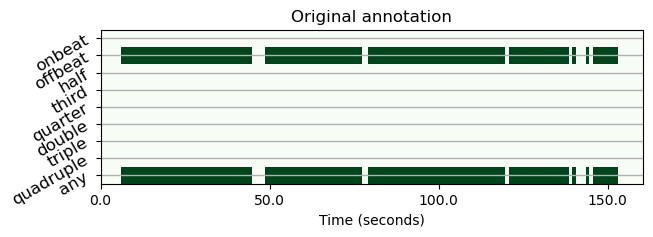

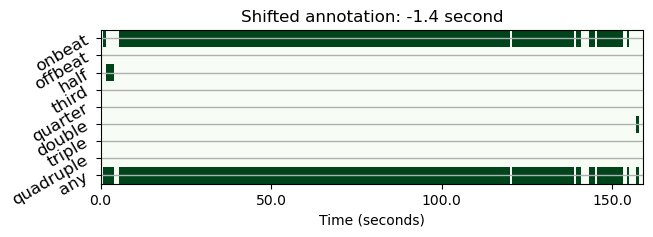

In [6]:
###################################################################################
# plot ACR (with original vs. shifted annotations) for full-track view first
###################################################################################
src_dict = getSRCs(selected_track)

beat_est = np.loadtxt(src_dict['estipath'])
ann_ori = np.loadtxt(src_dict['annpath'])[:, 0]
ann_shift = ann_ori + annshift/1000
L=2

###------------###
 # original ACR  #
###------------###
fig = fullTrackACR(beat_est, ann_ori, title = 'Original annotation', fontsize = 12)
# shift_title = 'shifted annotation:{}ms'.format(annshift)
shift_title = 'Shifted annotation: {} second'.format(annshift/1000)
fig2 = fullTrackACR(beat_est, ann_shift, title = shift_title, fontsize = 12 )


In [7]:
###------------###
 # sonification  #
###------------###
audio, rate = sf.read(src_dict['wavpath'])

### stereo tracks
if len(audio.shape)==2:
    audio = audio.mean(axis = 1)
print("==="*20)
print("Track Name:{}".format(os.path.basename(songpath)))
print("==="*20)
print("---> duration:{:.2f} sec, sampling rate:{}".format(len(audio)/rate, rate))

print("================")
print("original audio")
print("================")
# ipd.display(ipd.Audio(audio, rate = rate))

print("====================")
print("original annotations")
print("====================")
### play audio with click
print("annotation path:{}".format(src_dict['annpath']))
audio_click = add_click(audio, ann_ori, rate)
# print(audio.shape)
# ipd.display(ipd.Audio(audio_click, rate = rate))

print("============================================")
print("shifted annotations : {} second".format(annshift/1000))
print("============================================")
### play audio with click
audio_click = add_click(audio, ann_shift, rate)
# print(audio.shape)
# ipd.display(ipd.Audio(audio_click, rate = rate))

print("============================================")
print("simple peak picking estimations")
print("============================================")
### play audio with click
audio_click = add_click(audio, beat_est, rate)
# print(audio.shape)
# ipd.display(ipd.Audio(audio_click, rate = rate))

Track Name:Bach_Fugue_bwv_883_KaiRuiR03.wav
---> duration:163.50 sec, sampling rate:48000
original audio
original annotations
annotation path:./annotations/Bach_Fugue_bwv_883_KaiRuiR03.beats
shifted annotations : -1.4 second
simple peak picking estimations


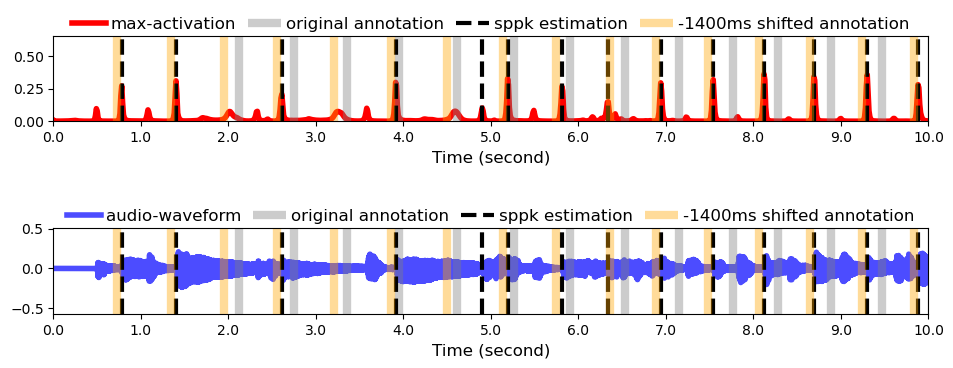

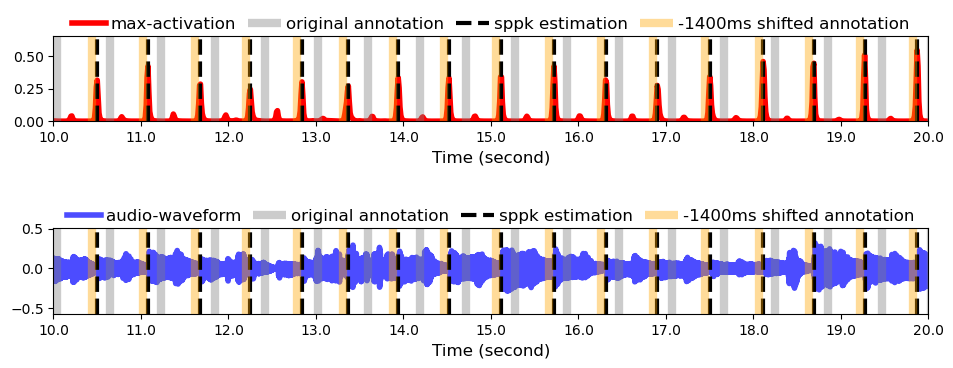

In [8]:
###############################################
### for loop to visualize the first 20 seconds
###############################################

fontsize=12
for start_frame in np.arange(0, 2000, 1000):
    plotSRCs(src_dict, annshift, figsize = figsize, fontsize = fontsize, start_frame = start_frame, dur = 1000)



Track duration: 163.50 seconds


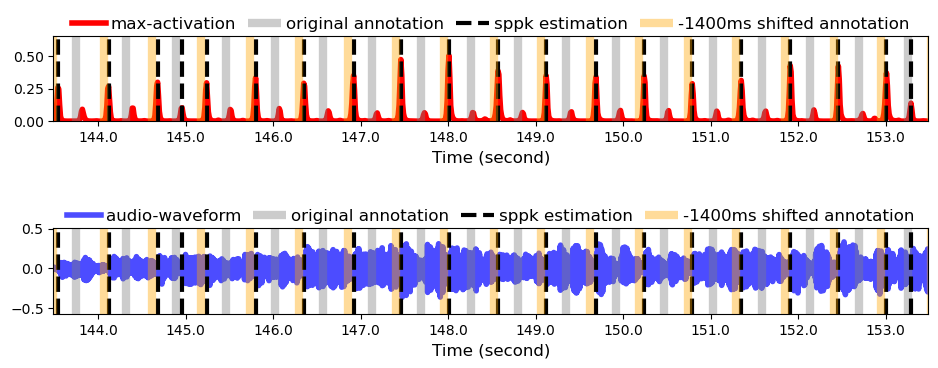

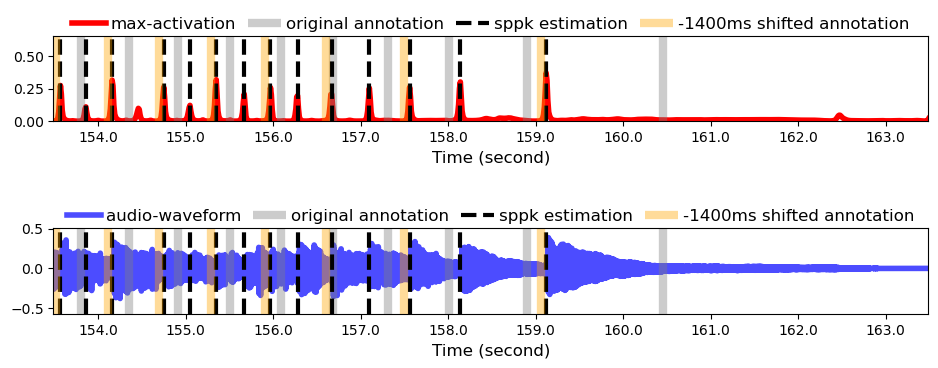

In [9]:
###############################################
### for loop to visualize the last 20 seconds
###############################################

song_dur = len(audio)/rate
print('Track duration: {:.2f} seconds'.format(song_dur))
start_frame1 = int(Beat_FPS*(song_dur-20))

for start_frame in [start_frame1, start_frame1+1000]:
    plotSRCs(src_dict, annshift, figsize = figsize, fontsize = fontsize, start_frame = start_frame, dur = 1000)

